In [1]:
from meteostream import GefsClient

In [2]:
# Grab some test data
client = GefsClient("/home/tylerradebaugh/data/grib",
                    prob_idx_list=[38],
                    forecast_hours=(0,27,3))

In [3]:
client.download_gefs_data()

Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.prob.global.0p25.f000.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.prob.global.0p25.f003.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.prob.global.0p25.f006.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.prob.global.0p25.f009.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.prob.global.0p25.f012.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.prob.global.0p25.f015.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.prob.global.0p25.f018.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.prob.global.0p25.f021.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.prob.global.0p25.f024.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.mean.global.0p25.f000.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t12z.mean.global.0p25.f003.grib2
Downloaded: /home/tylerradebaugh/data/grib/gefs.wave.t

In [4]:
import pygrib

with pygrib.open("/home/tylerradebaugh/data/grib/gefs.wave.t12z.mean.global.0p25.f024.grib2") as grbs:
    for grb in grbs:
        print(grb.shortName)

swh
perpw
dirpw
shww
mpww
wvdir
ws
wdir
shts
shts
mpts
mpts


In [3]:
client.check_download = True
ds = client.run_GEFS_pipeline(save_file=None, return_ds=True, clear_gribs=False)

Preprocessing files..this might take some time
Processing /home/tylerradebaugh/data/grib/gefs.wave.t12z.mean.global.0p25.f000.grib2...
Target idx: 1, Name: swh, Tau:000
Creating DataArray for swh
Target idx: 7, Name: ws, Tau:000
Creating DataArray for avg_ws
Target idx: 8, Name: wdir, Tau:000
Creating DataArray for wdir
Processing /home/tylerradebaugh/data/grib/gefs.wave.t12z.mean.global.0p25.f003.grib2...
Target idx: 1, Name: swh, Tau:003
Creating DataArray for swh
Target idx: 7, Name: ws, Tau:003
Creating DataArray for avg_ws
Target idx: 8, Name: wdir, Tau:003
Creating DataArray for wdir
Processing /home/tylerradebaugh/data/grib/gefs.wave.t12z.mean.global.0p25.f006.grib2...
Target idx: 1, Name: swh, Tau:006
Creating DataArray for swh
Target idx: 7, Name: ws, Tau:006
Creating DataArray for avg_ws
Target idx: 8, Name: wdir, Tau:006
Creating DataArray for wdir
Processing /home/tylerradebaugh/data/grib/gefs.wave.t12z.mean.global.0p25.f009.grib2...
Target idx: 1, Name: swh, Tau:009
Creati

In [4]:
ds  

<xarray.Dataset> Size: 598MB
Dimensions:     (valid_time: 18, latitude: 721, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.3 359.5 359.8
  * valid_time  (valid_time) datetime64[ns] 144B 2025-02-17T12:00:00 ... 2025...
    ref_time    datetime64[ns] 8B 2025-02-17T12:00:00
Data variables:
    swh         (valid_time, latitude, longitude) float64 150MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    avg_ws      (valid_time, latitude, longitude) float64 150MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wdir        (valid_time, latitude, longitude) float64 150MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wsBF8       (valid_time, latitude, longitude) float64 150MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    grb_Param_Index:  [38]
    Description:      GEFS Probability Data from NOAA NOMADS HTTPS
    Parameter_38:     ('Wind speed', 'Prob. > 17.48')

In [22]:
import metpy.calc as mpcalc
from metpy.units import units

# Get the mean wind data for streamplot
avg_wspd = ds['avg_ws'] 
avg_wdir = ds['wdir'] 

# u, v = mpcalc.wind_components(avg_wspd, avg_wdir)
# print(u.max().values)

print(avg_wdir.mean().values)

4508.12232571681


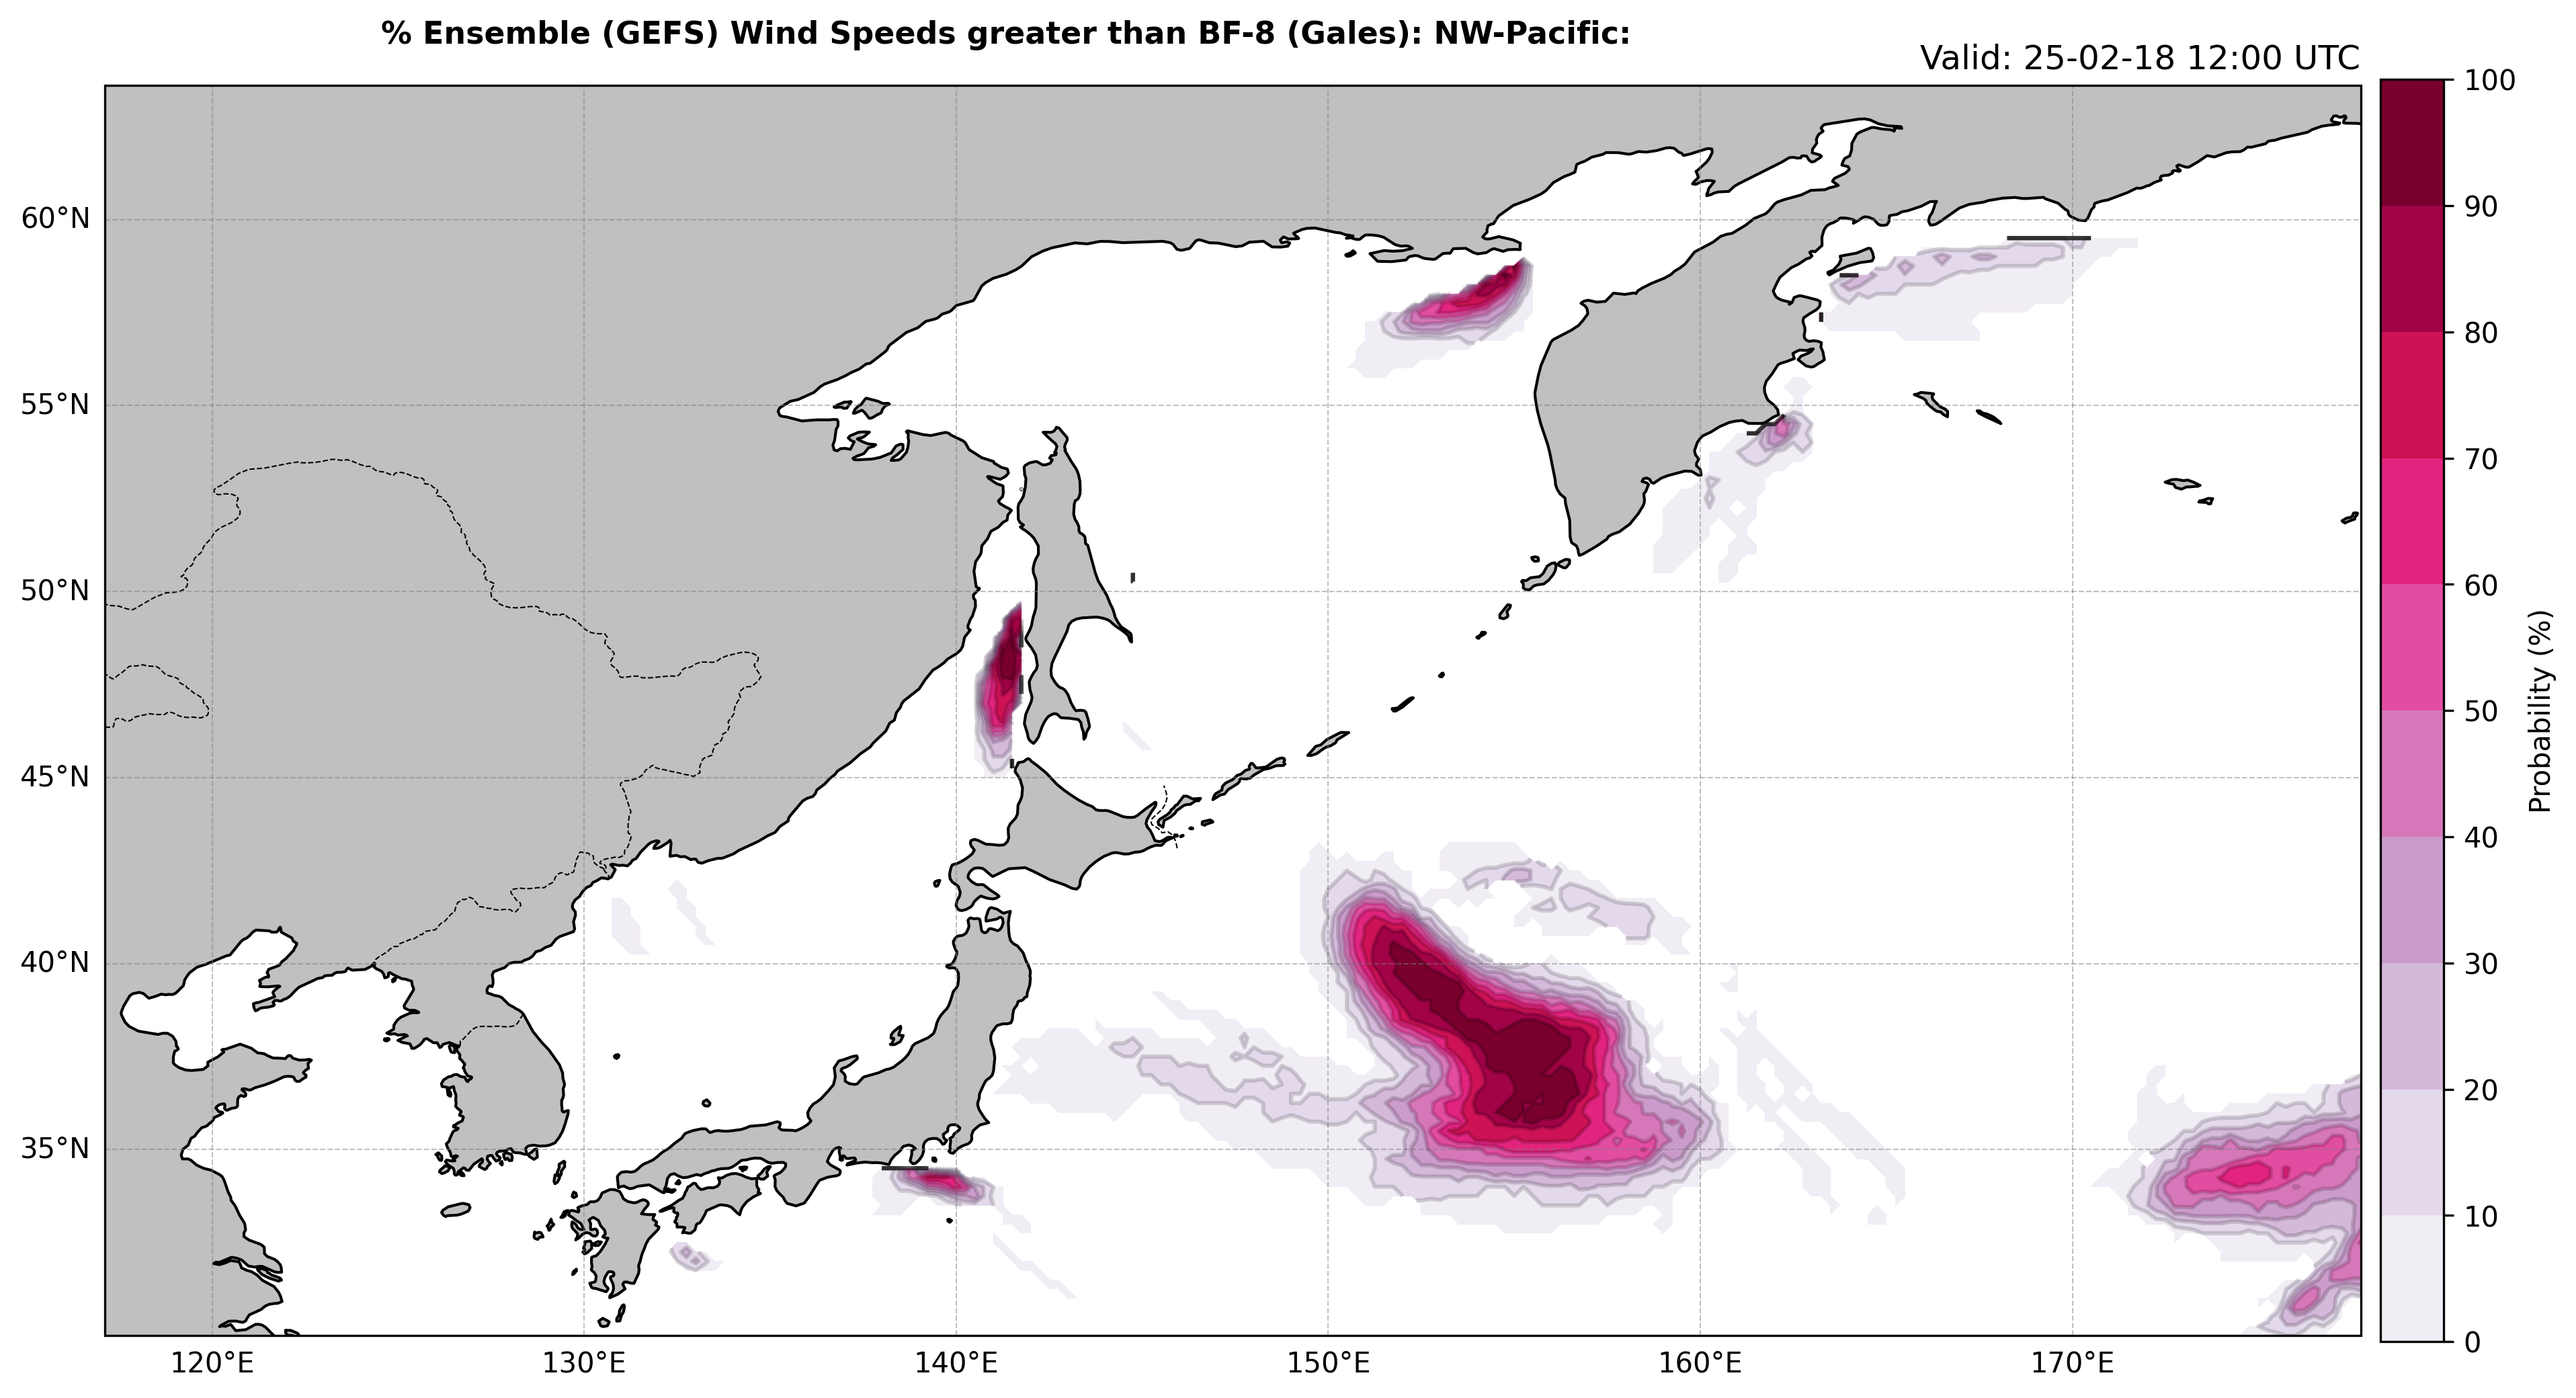

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import numpy as np
import xarray as xr
import pandas as pd

import metpy.calc as mpcalc

proc_ds = ds.isel(valid_time=-1)
data = proc_ds.sel(latitude=slice(62, 30), longitude=slice(120, 178))

#Prob data
masked_data = xr.where(data['wsBF8'] == 0, np.nan, data)
lats = data['latitude'].values
lons = data['longitude'].values
time = data['valid_time'].values
timestamp = pd.to_datetime(time).strftime("%y-%m-%d %H:%M UTC")

# Get the mean wind data for streamplot
avg_wspd = data['avg_ws']
avg_wdir = data['wdir']

u, v = mpcalc.wind_components(avg_wspd, avg_wdir)

levels = np.arange(0.0, 1.10, 0.10)

fig = plt.figure(figsize=(14,7), dpi=300)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title(f"Valid: {timestamp}", loc="right")
ax.add_feature(cfeature.LAND, facecolor='silver', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot data
cf = ax.contourf(lons, lats, masked_data['wsBF8'], cmap='PuRd', levels = levels, transform=ccrs.PlateCarree())
ax.contour(lons, lats, masked_data['wsBF8'], levels=np.arange(0, 1.1, 0.1), colors='black', transform=ccrs.PlateCarree(), alpha=0.15)
ax.streamplot(lons, lats, u.values, v.values, density=0.5, linewidth=1, color='black', transform=ccrs.PlateCarree())

cbar = plt.colorbar(cf, ax=ax, 
                    label='Probability (%)', pad=0.0075)
cbar.set_ticks(levels)
cbar.set_ticklabels(['0', '10', '20', '30','40', '50', 
                     '60', '70', '80', '90', '100'])


plt.suptitle(f"% Ensemble (GEFS) Wind Speeds greater than BF-8 (Gales): NW-Pacific:",
             fontsize=11, x=0.36, y=0.97, fontweight='bold')

fig.tight_layout()


In [ ]:
# Configure levels for contour plot
levels = np.arange(0.0, 1.10, 0.10)

# Function to update each frame
def update(frame):
    plt.clf()  # Clear the current figure to avoid overlapping plots

    # Select data for the current frame
    proc_ds = ds.isel(valid_time=frame)
    data = proc_ds['wsBF8'].sel(latitude=slice(62, 30), longitude=slice(120, 178))
    masked_data = xr.where(data == 0, np.nan, data)

    # Get coordinates and time
    lats = data['latitude'].values
    lons = data['longitude'].values
    time = data['valid_time'].values
    timestamp = pd.to_datetime(time).strftime("%y-%m-%d %H:%M UTC")

    # Create the plot
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_title(f"Valid: {timestamp}", loc="right")
    ax.add_feature(cfeature.LAND, facecolor='silver', edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Contour plot
    cf = ax.contourf(lons, lats, masked_data, cmap='PuRd', levels=levels, transform=ccrs.PlateCarree())
    ax.contour(lons, lats, masked_data, levels=levels, colors='black', transform=ccrs.PlateCarree(), alpha=0.15)

    # Add colorbar
    cbar = plt.colorbar(cf, ax=ax, label='Probability (%)', pad=0.0075)
    cbar.set_ticks(levels)
    cbar.set_ticklabels(['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'])

    # Add title
    plt.suptitle(f"% Ensemble (GEFS) Wind Speeds greater than BF-8 (Gales): NW-Pacific:",
                 fontsize=11, x=0.36, y=0.97, fontweight='bold')

# Set up the animation
fig = plt.figure(figsize=(14, 7), dpi=300)
ani = animation.FuncAnimation(fig, update, frames=len(ds['valid_time']), interval=500)
